In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4MB 6.5MB/s eta 0:00:01
     |████████████████████████████████| 9.5MB 40.6MB/s eta 0:00:01
     |████████████████████████████████| 14.8MB 30.3MB/s eta 0:00:01
     |████████████████████████████████| 25.9MB 27.4MB/s eta 0:00:01
     |████████████████████████████████| 22.3MB 49.5MB/s eta 0:00:01
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: tsfresh 0.12.0 has requirement pandas<=0.23.4,>=0.20.3, but you'll have pandas 0.25.2 which is incompatible.
ERROR: tensorflow-probability 0.8.0 has requirement cloudpickle==1.1.1, but you'll have cloudpickle 1.2.2 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requiremen

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv('/kaggle/input/final-data/final_data_ready.csv')
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Previous Close,Movement,Sentiment
Date,,,,,,,,,,,,
2019-06-20,2019-06-20,48.409701,48.467686,47.844354,48.189846,86056000,0.0,0,AAPL,47.805695,Increase,0.0000
2019-06-21,2019-06-21,48.030392,48.525675,47.873348,48.025558,191202400,0.0,0,AAPL,48.189846,Decrease,0.2500
2019-06-24,2019-06-24,47.967572,48.358969,47.878180,47.977238,72881600,0.0,0,AAPL,48.025558,Decrease,0.3182
2019-06-25,2019-06-25,47.941000,48.141530,47.182371,47.250023,84281200,0.0,0,AAPL,47.977238,Decrease,0.9381
2019-06-26,2019-06-26,47.781548,48.559506,47.680076,48.271999,104270000,0.0,0,AAPL,47.250023,Increase,0.2023


**Partition the dataframe for apple stocks**

In [4]:
df_aapl = (df[df['Ticker']=='AAPL']).copy()

In [5]:
df_aapl.drop(['Ticker'],axis=1,inplace=True)

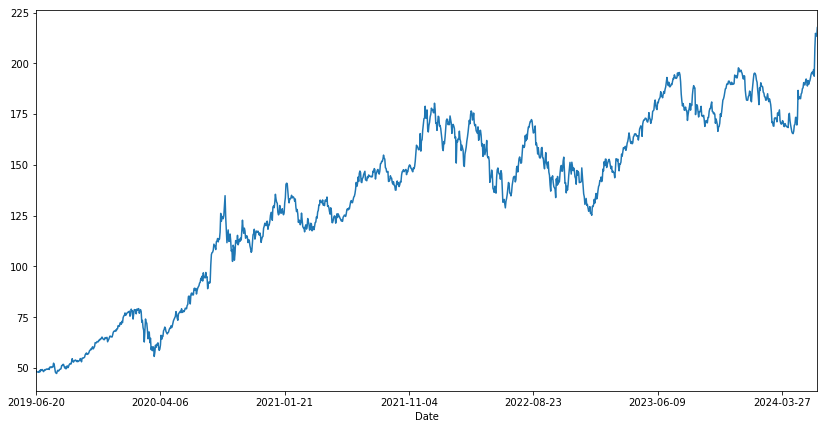

In [6]:
df_aapl.Open.plot(figsize=(14, 7))

**Add technical indicators for the model**

In [7]:
df_aapl.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df_aapl[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df_aapl[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df_aapl[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df_aapl[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df_aapl[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df_aapl[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df_aapl[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df_aapl[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df_aapl[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df_aapl.fillna(df_aapl.mean(), inplace=True)

df_aapl.set_index("Date", drop=False, inplace=True)
df_aapl.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Previous Close,Movement,...,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-20,2019-06-20,48.409701,48.467686,47.844354,48.189846,86056000,0.0,0,47.805695,Increase,...,131.044052,1.489431,2.336112,4.924371,96304672.0,96288360.0,96565608.0,18478110.0,23276460.0,29322000.0
2019-06-21,2019-06-21,48.030392,48.525675,47.873348,48.025558,191202400,0.0,0,48.189846,Decrease,...,47.844353,1.489431,2.336112,4.924371,86056000.0,86056000.0,86056000.0,18478110.0,23276460.0,29322000.0
2019-06-24,2019-06-24,47.967572,48.358969,47.878180,47.977238,72881600,0.0,0,48.025558,Decrease,...,47.858852,0.020502,0.020502,0.020502,138629200.0,138629200.0,138629200.0,74349736.0,74349736.0,74349736.0
2019-06-25,2019-06-25,47.941000,48.141530,47.182371,47.250023,84281200,0.0,0,47.977238,Decrease,...,47.865295,0.018295,0.018295,0.018295,116713336.0,116713336.0,116713336.0,64844868.0,64844868.0,64844868.0
2019-06-26,2019-06-26,47.781548,48.559506,47.680076,48.271999,104270000,0.0,0,47.250023,Increase,...,47.694565,0.400338,0.341788,0.341788,116121736.0,108605296.0,108605296.0,65271108.0,55373268.0,55373268.0


In [9]:
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'], utc=True)

In [10]:
df_aapl["month"] = df_aapl.Date.dt.month
df_aapl["week"] = df_aapl.Date.dt.week
df_aapl["day"] = df_aapl.Date.dt.day
df_aapl["day_of_week"] = df_aapl.Date.dt.dayofweek
df_aapl.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Previous Close,Movement,...,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-20,2019-06-20 00:00:00+00:00,48.409701,48.467686,47.844354,48.189846,86056000,0.0,0,47.805695,Increase,...,96304672.0,96288360.0,96565608.0,18478110.0,23276460.0,29322000.0,6,25,20,3
2019-06-21,2019-06-21 00:00:00+00:00,48.030392,48.525675,47.873348,48.025558,191202400,0.0,0,48.189846,Decrease,...,86056000.0,86056000.0,86056000.0,18478110.0,23276460.0,29322000.0,6,25,21,4
2019-06-24,2019-06-24 00:00:00+00:00,47.967572,48.358969,47.878180,47.977238,72881600,0.0,0,48.025558,Decrease,...,138629200.0,138629200.0,138629200.0,74349736.0,74349736.0,74349736.0,6,26,24,0
2019-06-25,2019-06-25 00:00:00+00:00,47.941000,48.141530,47.182371,47.250023,84281200,0.0,0,47.977238,Decrease,...,116713336.0,116713336.0,116713336.0,64844868.0,64844868.0,64844868.0,6,26,25,1
2019-06-26,2019-06-26 00:00:00+00:00,47.781548,48.559506,47.680076,48.271999,104270000,0.0,0,47.250023,Increase,...,116121736.0,108605296.0,108605296.0,65271108.0,55373268.0,55373268.0,6,26,26,2


In [11]:
df_train = (df_aapl.head(len(df) - 100)).copy()
df_valid_aapl = (df_aapl.tail(100)).copy() 

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3","Volume_mean_lag3", "Volume_std_lag3", 
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7","Volume_mean_lag7", "Volume_std_lag7", 
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30","Volume_mean_lag30", "Volume_std_lag30","month", "week", "day", "day_of_week",'Sentiment']

**Train the model on open and close data separately and plot them**

In [12]:
model = auto_arima(df_train.Open, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Open, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid_aapl), exogenous=df_valid_aapl[exogenous_features])
df_valid_aapl["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7103.073, Time=3.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6788.783, Time=2.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7039.869, Time=1.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7130.124, Time=2.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14508.482, Time=1.71 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7118.017, Time=2.71 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 14.344 seconds


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


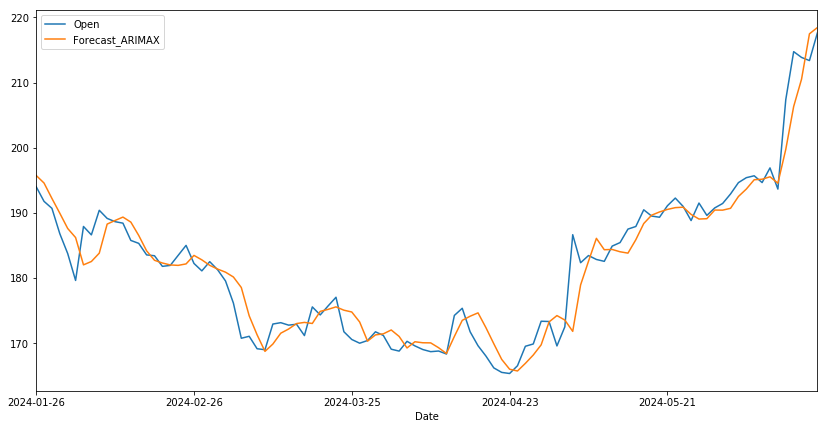

In [13]:
df_valid_aapl[["Open", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [14]:
model = auto_arima(df_train.Close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast_close = model.predict(n_periods=len(df_valid_aapl), exogenous=df_valid_aapl[exogenous_features])
df_valid_aapl["Forecast_ARIMAX_close"] = forecast_close

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7108.273, Time=2.93 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7099.923, Time=1.88 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7056.219, Time=1.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7177.480, Time=2.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14819.634, Time=1.73 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=7093.210, Time=2.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7114.651, Time=2.72 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7110.854, Time=2.85 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7052.317, Time=1.78 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7090.496, Time=2.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7111.765, Time=2.60 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7174.769, Time=2.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7106.630, Time=2.67 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 31.458 seconds


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


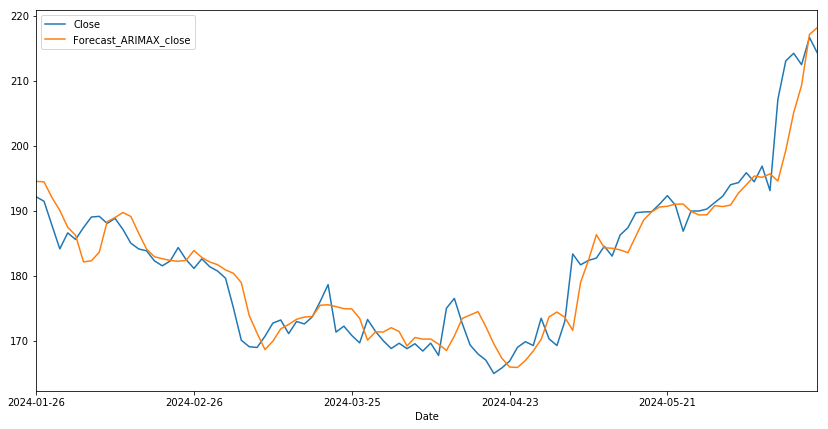

In [15]:
df_valid_aapl[["Close", "Forecast_ARIMAX_close"]].plot(figsize=(14, 7))

**Partition the dataframe for microsoft stocks**

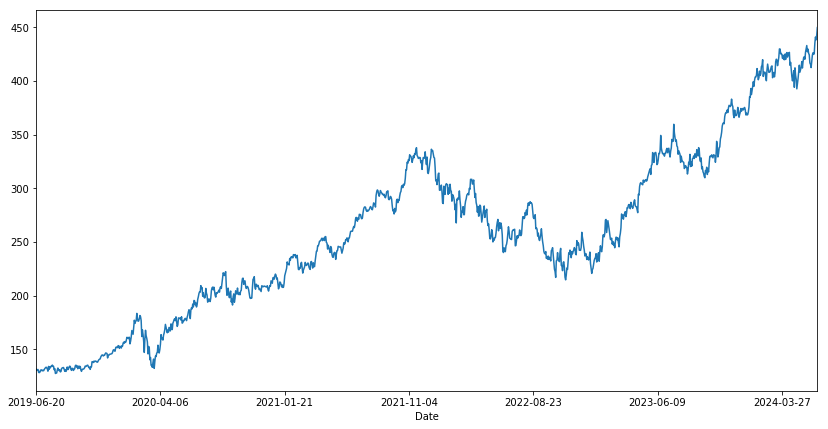

In [18]:
df_msft = (df[df['Ticker']=='MSFT']).copy()
df_msft.drop(['Ticker'],axis=1,inplace=True)
df_msft.Open.plot(figsize=(14, 7))

**Add technical indicators for the model**

In [19]:
df_msft.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df_msft[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df_msft[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df_msft[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df_msft[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df_msft[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df_msft[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df_msft[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df_msft[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df_msft[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df_msft.fillna(df_msft.mean(), inplace=True)

df_msft.set_index("Date", drop=False, inplace=True)

In [20]:
df_msft['Date'] = pd.to_datetime(df_msft['Date'], utc=True)
df_msft["month"] = df_msft.Date.dt.month
df_msft["week"] = df_msft.Date.dt.week
df_msft["day"] = df_msft.Date.dt.day
df_msft["day_of_week"] = df_msft.Date.dt.dayofweek

In [21]:
df_train = (df_msft.head(len(df) - 100)).copy()
df_valid_msft = (df_msft.tail(100)).copy() 

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3","Volume_mean_lag3", "Volume_std_lag3", 
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7","Volume_mean_lag7", "Volume_std_lag7", 
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30","Volume_mean_lag30", "Volume_std_lag30","month", "week", "day", "day_of_week",'Sentiment']

**Train the model on open and close data separately and plot them**


In [22]:
model = auto_arima(df_train.Open, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Open, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid_msft), exogenous=df_valid_msft[exogenous_features])
df_valid_msft["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8114.527, Time=3.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7975.656, Time=1.81 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8102.785, Time=1.88 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8146.751, Time=2.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15695.356, Time=1.73 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8144.730, Time=2.64 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 14.120 seconds


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [24]:
model = auto_arima(df_train.Close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast_close = model.predict(n_periods=len(df_valid_msft), exogenous=df_valid_msft[exogenous_features])
df_valid_msft["Forecast_ARIMAX_close"] = forecast_close

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8242.902, Time=2.98 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8332.623, Time=1.93 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8229.876, Time=4.72 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8296.619, Time=2.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16052.323, Time=1.80 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8235.278, Time=2.77 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8251.002, Time=2.96 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8246.014, Time=7.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8226.830, Time=1.80 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8232.904, Time=2.53 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8248.519, Time=2.60 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8294.212, Time=2.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8243.277, Time=2.68 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 38.901 seconds


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


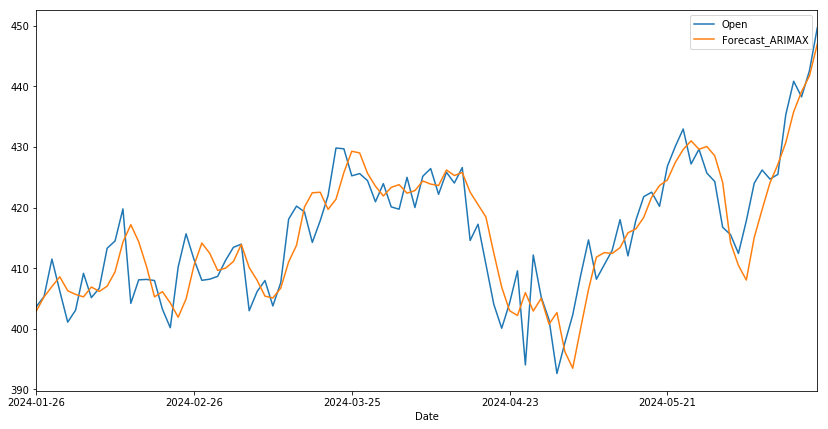

In [25]:
df_valid_msft[["Open", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

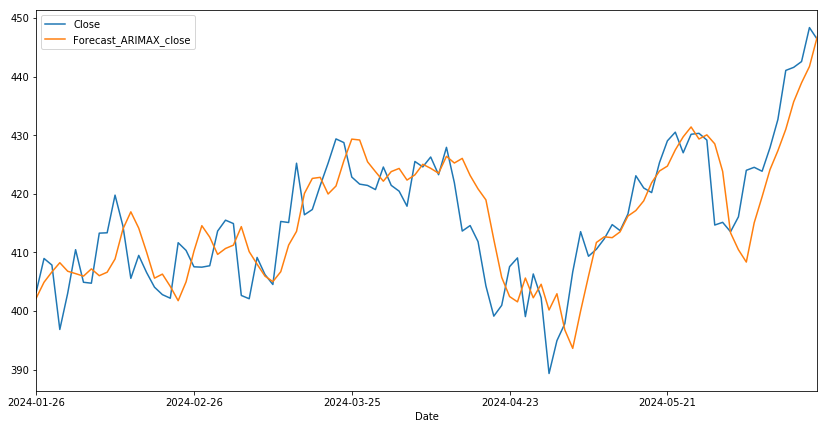

In [26]:
df_valid_msft[["Close", "Forecast_ARIMAX_close"]].plot(figsize=(14, 7))

**Partition the dataframe for google stocks**

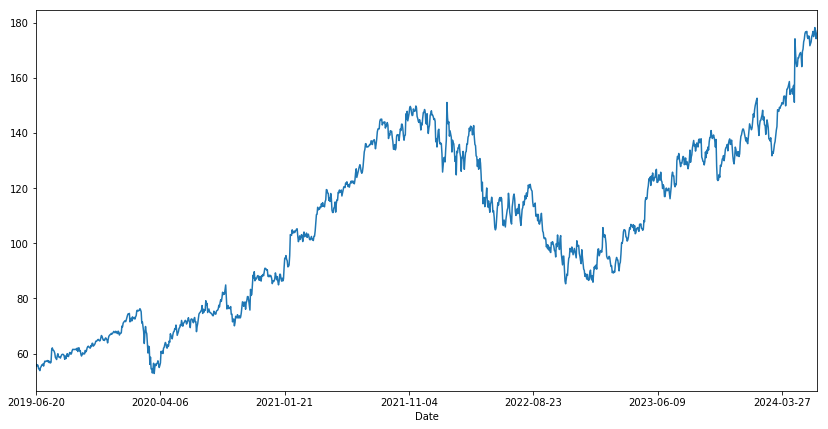

In [27]:
df_googl = (df[df['Ticker']=='GOOGL']).copy()
df_googl.drop(['Ticker'],axis=1,inplace=True)
df_googl.Open.plot(figsize=(14, 7))

**Add technical indicators for the model**

In [28]:
df_googl.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df_googl[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df_googl[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df_googl[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df_googl[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df_googl[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df_googl[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df_googl[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df_googl[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df_googl[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df_googl.fillna(df_googl.mean(), inplace=True)

df_googl.set_index("Date", drop=False, inplace=True)

In [29]:
df_googl['Date'] = pd.to_datetime(df_googl['Date'], utc=True)
df_googl["month"] = df_googl.Date.dt.month
df_googl["week"] = df_googl.Date.dt.week
df_googl["day"] = df_googl.Date.dt.day
df_googl["day_of_week"] = df_googl.Date.dt.dayofweek

In [30]:
df_train = (df_googl.head(len(df) - 100)).copy()
df_valid_googl = (df_googl.tail(100)).copy() 

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3","Volume_mean_lag3", "Volume_std_lag3", 
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7","Volume_mean_lag7", "Volume_std_lag7", 
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30","Volume_mean_lag30", "Volume_std_lag30","month", "week", "day", "day_of_week",'Sentiment']

**Train the model on open and close data separately and plot them**


In [31]:
model = auto_arima(df_train.Open, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Open, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid_googl), exogenous=df_valid_googl[exogenous_features])
df_valid_googl["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5962.029, Time=3.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6025.477, Time=1.79 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5977.463, Time=1.94 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6014.586, Time=2.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13745.205, Time=1.74 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5973.623, Time=2.87 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6042.369, Time=2.89 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5968.356, Time=3.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5958.398, Time=3.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5958.710, Time=2.93 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=5962.133, Time=3.16 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=5957.863, Time=3.82 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=5955.636, Time=3.55 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=5953.312, Time=3.53 sec
 ARIMA(0,0,3)(0,0,0)[0] intercep

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [32]:
model = auto_arima(df_train.Close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast_close = model.predict(n_periods=len(df_valid_googl), exogenous=df_valid_googl[exogenous_features])
df_valid_googl["Forecast_ARIMAX_close"] = forecast_close

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6132.272, Time=2.97 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6369.877, Time=1.81 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6147.299, Time=1.91 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6251.857, Time=2.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14089.592, Time=1.80 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6124.758, Time=2.83 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6113.711, Time=2.70 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=6123.268, Time=2.73 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6155.579, Time=2.68 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6131.533, Time=2.83 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6111.582, Time=2.80 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6249.636, Time=2.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6122.597, Time=2.66 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=6121.122, Time=2.59 sec
 ARIMA(1,0,1)(0,0,0)[0]         

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


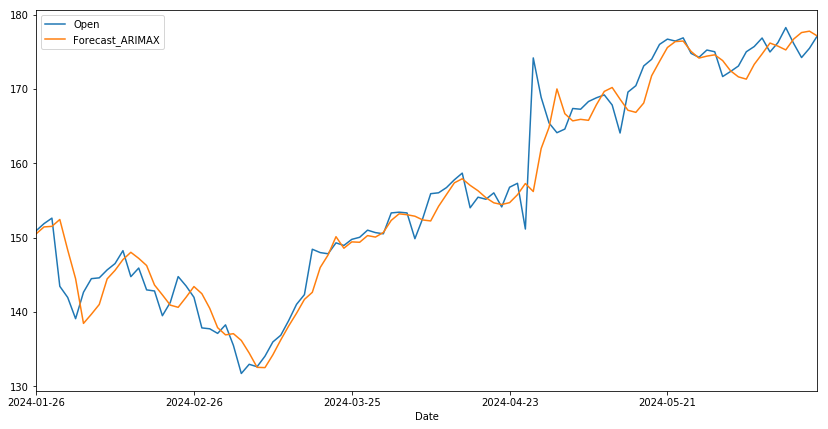

In [33]:
df_valid_googl[["Open", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

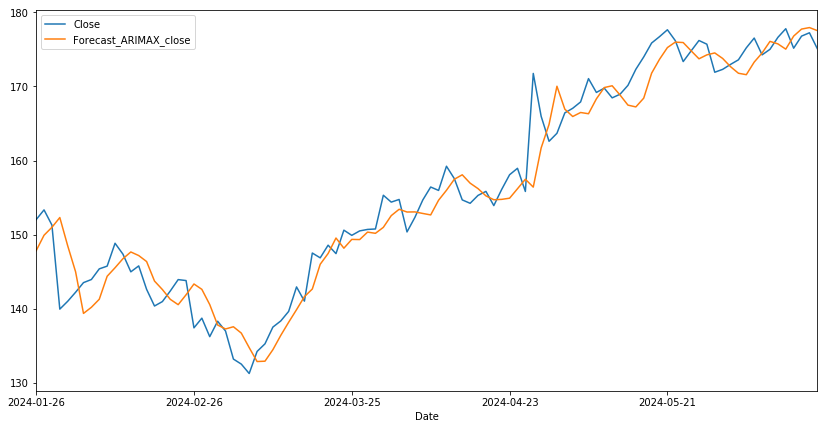

In [34]:
df_valid_googl[["Close", "Forecast_ARIMAX_close"]].plot(figsize=(14, 7))

**Partition the dataframe for amazon stocks**

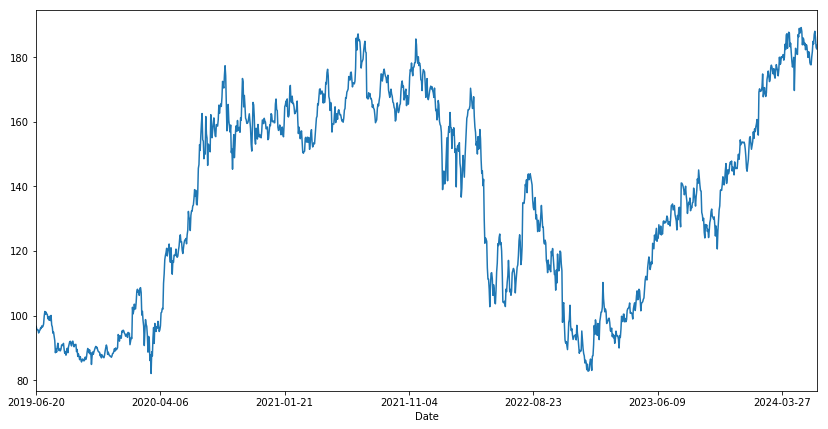

In [35]:
df_amzn = (df[df['Ticker']=='AMZN']).copy()
df_amzn.drop(['Ticker'],axis=1,inplace=True)
df_amzn.Open.plot(figsize=(14, 7))

**Add technical indicators for the model**

In [36]:
df_amzn.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df_amzn[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df_amzn[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df_amzn[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df_amzn[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df_amzn[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df_amzn[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df_amzn[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df_amzn[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df_amzn[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df_amzn.fillna(df_amzn.mean(), inplace=True)

df_amzn.set_index("Date", drop=False, inplace=True)

In [37]:
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'], utc=True)
df_amzn["month"] = df_amzn.Date.dt.month
df_amzn["week"] = df_amzn.Date.dt.week
df_amzn["day"] = df_amzn.Date.dt.day
df_amzn["day_of_week"] = df_amzn.Date.dt.dayofweek

In [38]:
df_train = (df_amzn.head(len(df) - 100)).copy()
df_valid_amzn = (df_amzn.tail(100)).copy() 

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3","Volume_mean_lag3", "Volume_std_lag3", 
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7","Volume_mean_lag7", "Volume_std_lag7", 
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30","Volume_mean_lag30", "Volume_std_lag30","month", "week", "day", "day_of_week",'Sentiment']

**Train the model on open and close data separately and plot them**


In [39]:
model = auto_arima(df_train.Open, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Open, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid_amzn), exogenous=df_valid_amzn[exogenous_features])
df_valid_amzn["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6288.158, Time=2.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6534.824, Time=1.80 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6360.753, Time=1.91 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6351.087, Time=3.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14254.521, Time=1.72 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6336.840, Time=2.78 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6312.002, Time=2.79 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6325.627, Time=3.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6278.056, Time=2.94 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6276.274, Time=2.83 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=6285.176, Time=2.72 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=6277.307, Time=3.52 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6330.600, Time=2.65 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=6276.371, Time=3.30 sec
 ARIMA(2,0,4)(0,0,0)[0] intercep

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [40]:
model = auto_arima(df_train.Close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast_close = model.predict(n_periods=len(df_valid_amzn), exogenous=df_valid_amzn[exogenous_features])
df_valid_amzn["Forecast_ARIMAX_close"] = forecast_close

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6520.074, Time=3.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6972.968, Time=1.86 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6597.834, Time=1.93 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6669.762, Time=2.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14692.697, Time=1.72 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6529.197, Time=2.87 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6527.914, Time=2.76 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6522.450, Time=3.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6518.782, Time=2.96 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6523.780, Time=2.83 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=6520.325, Time=3.17 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=6520.012, Time=4.64 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=6519.887, Time=3.56 sec


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=7177.583, Time=3.83 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6516.311, Time=2.89 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6519.788, Time=2.68 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6517.929, Time=2.82 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=6518.000, Time=2.91 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=6517.574, Time=3.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6527.130, Time=2.69 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=6517.423, Time=3.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6520.303, Time=3.14 sec


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=7175.490, Time=3.66 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 68.772 seconds


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


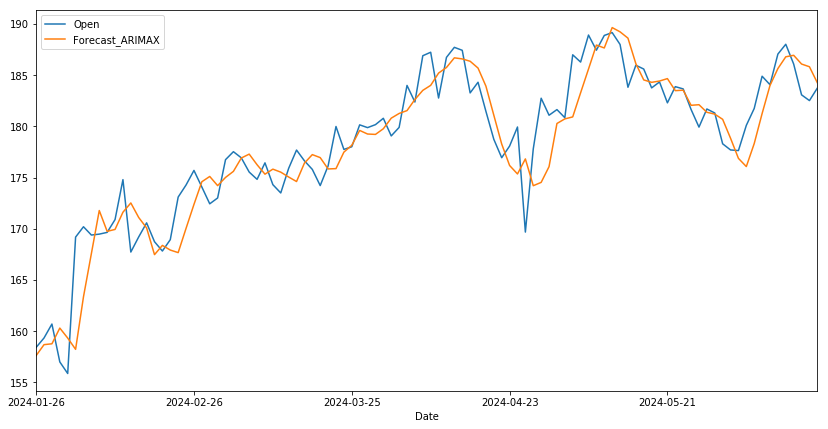

In [41]:
df_valid_amzn[["Open", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

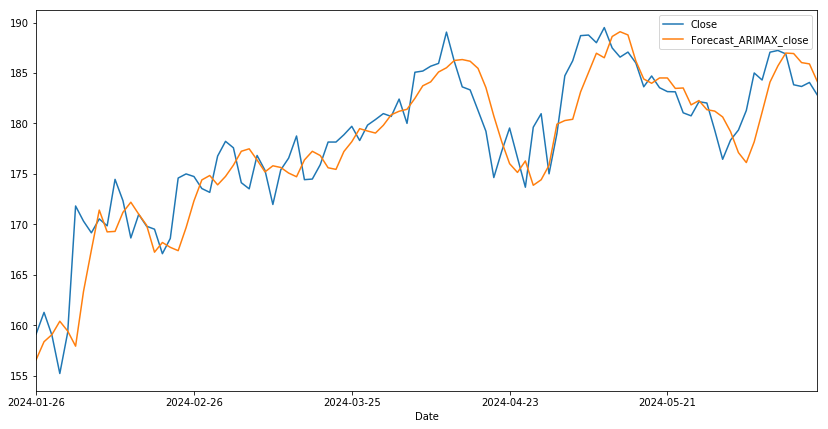

In [42]:
df_valid_amzn[["Close", "Forecast_ARIMAX_close"]].plot(figsize=(14, 7))

In [45]:
df_valid_aapl['Ticker'] = 'AAPL'
df_valid_msft['Ticker'] = 'MSFT'
df_valid_googl['Ticker'] = 'GOOGL'
df_valid_amzn['Ticker'] = 'AMZN'

In [58]:
df_all = pd.concat([df_valid_aapl, df_valid_msft, df_valid_googl, df_valid_amzn], axis=0)

In [59]:
df_all.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Previous Close,Movement,...,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,month,week,day,day_of_week,Forecast_ARIMAX,Forecast_ARIMAX_close,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-12,2024-06-12 00:00:00+00:00,188.020004,188.350006,185.429993,186.889999,33984200,0.0,0,187.229996,Decrease,...,3973581.5,2774802.50,18493688.0,6,24,12,2,186.795050,186.974283,AMZN
2024-06-13,2024-06-13 00:00:00+00:00,186.089996,187.669998,182.669998,183.830002,39721500,0.0,0,186.889999,Decrease,...,4034661.0,3131725.75,15356931.0,6,24,13,3,186.942601,186.925052,AMZN
2024-06-14,2024-06-14 00:00:00+00:00,183.080002,183.720001,182.229996,183.660004,25456400,0.0,0,183.830002,Decrease,...,6234645.5,4226384.50,11023421.0,6,24,14,4,186.089640,186.027350,AMZN
2024-06-17,2024-06-17 00:00:00+00:00,182.520004,185.000000,181.220001,184.059998,35601900,0.0,0,183.660004,Increase,...,7177895.0,4988360.50,10630795.0,6,25,17,0,185.823276,185.898478,AMZN
2024-06-18,2024-06-18 00:00:00+00:00,183.740005,184.289993,181.429993,182.809998,36659200,0.0,0,184.059998,Decrease,...,7341609.0,5224602.50,10603886.0,6,25,18,1,184.260280,184.151600,AMZN


In [65]:
import numpy as np
import pandas as pd

portfolio_weights = {
    'AAPL': 0.25,
    'MSFT': 0.25,
    'GOOGL': 0.25,
    'AMZN': 0.25
}

# Calculate daily returns for each stock
for ticker in portfolio_weights.keys():
    df_all[f'{ticker}_return'] = df_all[df_all['Ticker'] == ticker]['Close'].pct_change()

df_all['Portfolio_Return'] = sum(df_all[f'{ticker}_return'] * weight for ticker, weight in portfolio_weights.items())

# Calculate daily Sharpe Ratio for the portfolio
daily_returns = df_all['Portfolio_Return']
sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns)

# Calculate Maximum Drawdown
cumulative_returns = np.cumprod(1 + daily_returns.fillna(0)) - 1
max_drawdown = np.max(np.maximum.accumulate(cumulative_returns) - cumulative_returns)

# Number of Trades
num_trades = 0
position = 0  #1:long position

for i in range(1, len(df_all)):
    if df_all['Portfolio_Return'].iloc[i] > 0 and position == 0:  # Buy signal and no current position
        num_trades += 1
        position = 1
    elif df_all['Portfolio_Return'].iloc[i] < 0 and position == 1:  # Sell signal and holding long position
        num_trades += 1
        position = 0

# Win Ratio
positive_returns = daily_returns[daily_returns > 0]
win_ratio = len(positive_returns) / len(daily_returns) if len(daily_returns) > 0 else 0

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown:.2%}')
print(f'Number of Trades: {num_trades}')
print(f'Win Ratio: {win_ratio:.2%}')

Sharpe Ratio: 1.83
Maximum Drawdown: 10.25%
Number of Trades: 208
Win Ratio: 55.00%


In [68]:
print("RMSE of Auto ARIMAX open:", np.sqrt(mean_squared_error(df_all.Open, df_all.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX open:", mean_absolute_error(df_all.Open, df_all.Forecast_ARIMAX))

RMSE of Auto ARIMAX open: 3.611684255796013

MAE of Auto ARIMAX open: 2.5657522167943903


In [69]:
print("RMSE of Auto ARIMAX close:", np.sqrt(mean_squared_error(df_all.Close, df_all.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX close:", mean_absolute_error(df_all.Close, df_all.Forecast_ARIMAX_close))

RMSE of Auto ARIMAX close: 4.340052499816127

MAE of Auto ARIMAX close: 3.1557381018739297
